In [2]:
#导入必要的第三方库
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
np.random.seed(1)

In [3]:
InputPath = r"C:\biyesheji\LOLdataset\our485\high"

# Noise Addition

In [4]:
image_path =r"C:\biyesheji\LOLdataset\our485\high\21.png"
src = cv.imread(image_path)
if src is None:
    print("Error: Unable to read image at path:", image_path)
else:
    gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)

In [5]:
def addNoise(image, salt_pepper_ratio=0.5, amount=0.004):
    # 复制图像以避免修改原始图像
    noiseAddedImage = np.copy(image)
    num_salt = np.ceil(amount * image.size * salt_pepper_ratio)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_pepper_ratio))

    # 添加盐噪声
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    noiseAddedImage[coords[0], coords[1], :] = 1

    # 添加胡椒噪声
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    noiseAddedImage[coords[0], coords[1], :] = 0

    return noiseAddedImage

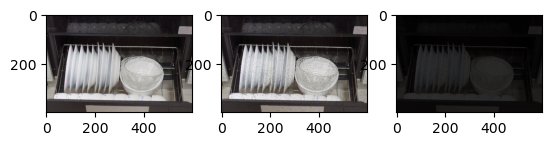

In [6]:
img = cv.imread(InputPath+"/100.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
Noise = addNoise(img)
plt.imshow(Noise)
plt.subplot(1,3,3)
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = addNoise(img1)
plt.imshow(Noise2)

# Data Preprocessing

In [7]:
from tqdm import tqdm
HighPath = r"C:\biyesheji\LOLdataset\our485\high"

def preprocess_image(imagePath):
    low_img = cv.imread(imagePath)
    if low_img is None:
        print("Failed to load image: ", imagePath)
        return None, None
    low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)  # 从BGR转为RGB
    low_img = cv.resize(low_img, (500, 500))
    hsv = cv.cvtColor(low_img, cv.COLOR_RGB2HSV)  # 转换到HSV
    hsv[..., 2] = hsv[..., 2] * 0.2
    img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)  # 将调整后的图像转回RGB
    Noisy_img = addNoise(img_1)
    return Noisy_img, low_img

def batch_generator(ImagePath, batch_size=10):
    file_names = os.listdir(ImagePath)
    for i in tqdm(range(0, len(file_names), batch_size)):
        X_, y_ = [], []
        for file_name in file_names[i:i + batch_size]:
            imagePath = os.path.join(ImagePath, file_name)
            Noisy_img, low_img = preprocess_image(imagePath)
            if Noisy_img is None or low_img is None:  # 图像加载失败的情况
                continue
            X_.append(Noisy_img)
            y_.append(low_img)
        yield np.array(X_), np.array(y_)
for X_batch, y_batch in batch_generator(HighPath, batch_size=10):
     pass

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.77it/s]


# Model Creation

In [8]:
import tensorflow as tf
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
# 清除之前的模型
K.clear_session()
# 定义模型函数
def InstantiateModel(in_):
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    return model_5
# 创建模型的输入层
Input_Sample = Input(shape=(500, 500,3))

# 调用定义的模型函数创建模型
Output_ = InstantiateModel(Input_Sample)

# 创建 Keras 模型
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

# 编译模型
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')

# 打印模型概况
Model_Enhancer.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 500, 500, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 500, 500, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 500, 500, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 500, 500, 32)      │           4,640 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 500, 500, 64)      │           8,256 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 500, 500, 64)      │           8,256 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 500, 500, 64)      │          16,448 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 500, 500, 64)      │               0 │ conv2d_2[0][0],            │
│                               │                           │                 │ conv2d_4[0][0],            │
│                               │                           │                 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 500, 500, 64)      │          36,928 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 500, 500, 32)      │          18,464 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 500, 500, 32)      │          18,464 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 500, 500, 16)      │           2,064 │ conv2d_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 500, 500, 16)      │           4,112 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 500, 500, 16)      │           2,064 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 500, 500, 16)      │               0 │ conv2d_10[0][0],           │
│                               │                           │                 │ conv2d_11[0][0],           │
│                               │                           │                 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 500, 500, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_17 (Conv2D)            │ (None, 500, 500, 16)      │             448 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 500, 500, 32)      │             896 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_18 (Conv2D)            │ (None, 500, 500, 32)      │           4,640 │ conv2d_17[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 500, 500, 64)      │           8,256 │ conv2d_20[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 500, 500, 64)      │           8,256 │ conv2d_18[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_22 (Conv2D)            │ (None, 500, 500, 64)      │          16,448 │ conv2d_21[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 500, 500, 64)      │               0 │ conv2d_19[0][0],           │
│                               │                           │                 │ conv2d_21[0][0],           │
│                               │                           │                 │ conv2d_22[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_23 (Conv2D)            │ (None, 500, 500, 64)      │          36,928 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 500, 500, 32)      │          18,464 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 500, 500, 32)      │          18,464 │ conv2d_23[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_27 (Conv2D)            │ (None, 500, 500, 16)      │           2,064 │ conv2d_26[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 500, 500, 16)      │           4,112 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 500, 500, 16)      │           2,064 │ conv2d_24[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 500, 500, 16)      │               0 │ conv2d_27[0][0],           │
│                               │                           │                 │ conv2d_28[0][0],           │
│                               │                           │                 │ conv2d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

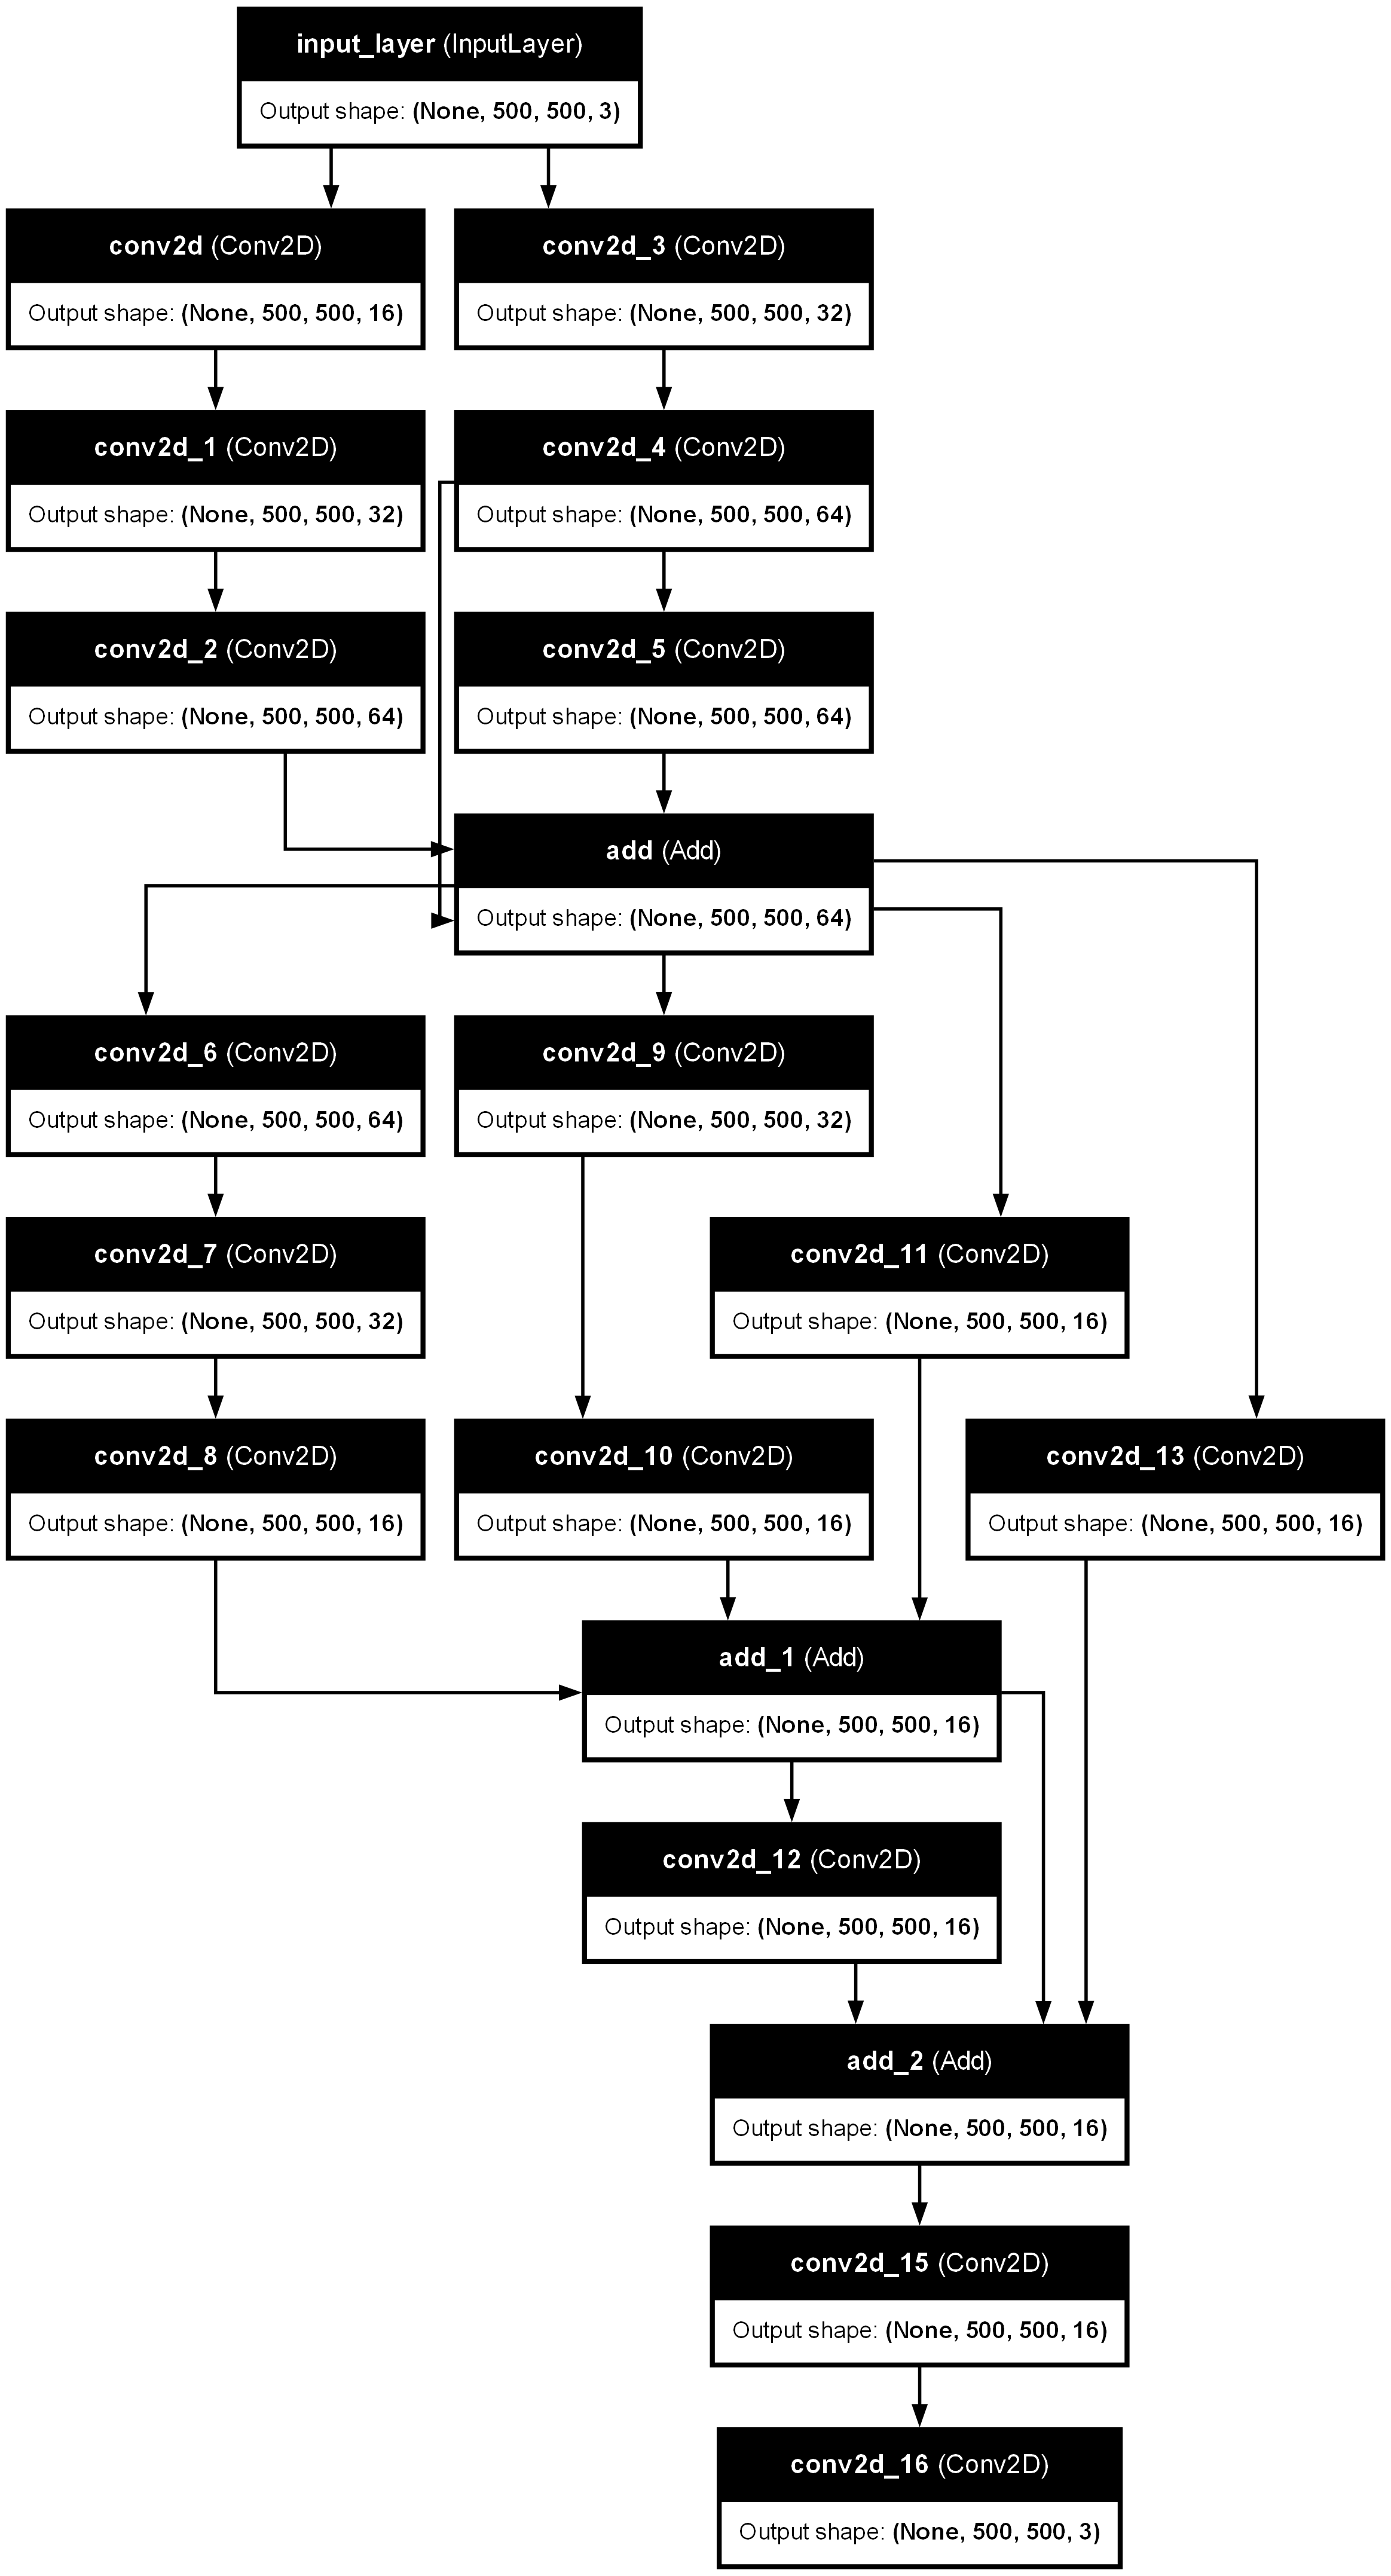

In [13]:
#SVG(model_to_dot(Model_Enhancer, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
from PIL import Image as PILImage
from IPython.display import display
image_path = 'model_.png'
img = PILImage.open(image_path)
display(img)


# Training

In [14]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit(batch_generator(HighPath, batch_size=10), epochs=49, verbose=1, steps_per_epoch=1, shuffle=True) #epochs * steps_per_epoch <= training dataset images...

  2%|█▋                                                                                 | 1/49 [00:00<00:04,  9.63it/s]

Epoch 1/49
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 13433.5654
Epoch 2/49


  4%|███▍                                                                               | 2/49 [00:14<06:32,  8.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 13787.3779
Epoch 3/49


  6%|█████                                                                              | 3/49 [00:24<06:54,  9.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 14564.6152
Epoch 4/49


  8%|██████▊                                                                            | 4/49 [00:33<06:50,  9.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 13478.4248
Epoch 5/49


 10%|████████▍                                                                          | 5/49 [00:42<06:42,  9.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 13498.3564
Epoch 6/49


 12%|██████████▏                                                                        | 6/49 [00:52<06:42,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 10694.5020
Epoch 7/49


 14%|███████████▊                                                                       | 7/49 [01:01<06:29,  9.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 10761.6416
Epoch 8/49


 16%|█████████████▌                                                                     | 8/49 [01:10<06:18,  9.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 11533.2314
Epoch 9/49


 18%|███████████████▏                                                                   | 9/49 [01:19<06:07,  9.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 10058.2949
Epoch 10/49


 20%|████████████████▋                                                                 | 10/49 [01:28<05:58,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 12308.5518
Epoch 11/49


 22%|██████████████████▍                                                               | 11/49 [01:38<05:54,  9.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 9835.7539
Epoch 12/49


 24%|████████████████████                                                              | 12/49 [01:47<05:44,  9.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 11253.0479
Epoch 13/49


 27%|█████████████████████▊                                                            | 13/49 [01:56<05:34,  9.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 10641.8145
Epoch 14/49


 29%|███████████████████████▍                                                          | 14/49 [02:06<05:27,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 7370.6709
Epoch 15/49


 31%|█████████████████████████                                                         | 15/49 [02:15<05:17,  9.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 7970.2314
Epoch 16/49


 33%|██████████████████████████▊                                                       | 16/49 [02:25<05:07,  9.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 8947.3340
Epoch 17/49


 35%|████████████████████████████▍                                                     | 17/49 [02:34<04:57,  9.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 5689.0566
Epoch 18/49


 37%|██████████████████████████████                                                    | 18/49 [02:43<04:45,  9.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 4792.8242
Epoch 19/49


 39%|███████████████████████████████▊                                                  | 19/49 [02:52<04:35,  9.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 4741.0986
Epoch 20/49


 41%|█████████████████████████████████▍                                                | 20/49 [03:01<04:26,  9.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 4561.8945
Epoch 21/49


 43%|███████████████████████████████████▏                                              | 21/49 [03:10<04:17,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 3519.8911
Epoch 22/49


 45%|████████████████████████████████████▊                                             | 22/49 [03:20<04:13,  9.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 5795.8477
Epoch 23/49


 47%|██████████████████████████████████████▍                                           | 23/49 [03:30<04:06,  9.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 8342.7539
Epoch 24/49


 49%|████████████████████████████████████████▏                                         | 24/49 [03:39<03:57,  9.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 7201.6475
Epoch 25/49


 51%|█████████████████████████████████████████▊                                        | 25/49 [03:49<03:48,  9.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 6008.0601
Epoch 26/49


 53%|███████████████████████████████████████████▌                                      | 26/49 [03:58<03:38,  9.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 4506.4966
Epoch 27/49


 55%|█████████████████████████████████████████████▏                                    | 27/49 [04:08<03:32,  9.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 5481.4458
Epoch 28/49


 57%|██████████████████████████████████████████████▊                                   | 28/49 [04:19<03:25,  9.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 3276.1802
Epoch 29/49


 59%|████████████████████████████████████████████████▌                                 | 29/49 [04:28<03:11,  9.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 2293.3655
Epoch 30/49


 61%|██████████████████████████████████████████████████▏                               | 30/49 [04:37<03:01,  9.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 1616.9601
Epoch 31/49


 63%|███████████████████████████████████████████████████▉                              | 31/49 [04:46<02:49,  9.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 847.1154
Epoch 32/49


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [04:55<02:38,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 746.7908
Epoch 33/49


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [05:05<02:29,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 556.4172
Epoch 34/49


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [05:14<02:19,  9.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 341.8670
Epoch 35/49


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [05:23<02:10,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 455.8463
Epoch 36/49


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [05:33<02:03,  9.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 947.0511
Epoch 37/49


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [05:43<01:53,  9.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 1092.6919
Epoch 38/49


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [05:52<01:44,  9.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 641.0275
Epoch 39/49


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [06:01<01:33,  9.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 690.6701
Epoch 40/49


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [06:11<01:24,  9.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 587.8699
Epoch 41/49


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [06:20<01:14,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 299.6897
Epoch 42/49


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [06:29<01:04,  9.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 334.1112
Epoch 43/49


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [06:38<00:55,  9.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 521.1068
Epoch 44/49


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [06:48<00:46,  9.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 320.5219
Epoch 45/49


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [06:58<00:37,  9.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 270.0110
Epoch 46/49


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [07:07<00:28,  9.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 316.9620
Epoch 47/49


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [07:18<00:19,  9.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 236.1170
Epoch 48/49


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [07:30<00:10, 10.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 207.9632
Epoch 49/49


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [07:42<00:00,  9.43s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 429.2850


In [15]:
TestPath= r"C:\biyesheji\LOLdataset\our485\high"

In [16]:
#定义函数，使数据转变为能被CNN模型处理的shape
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = addNoise(img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

# Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


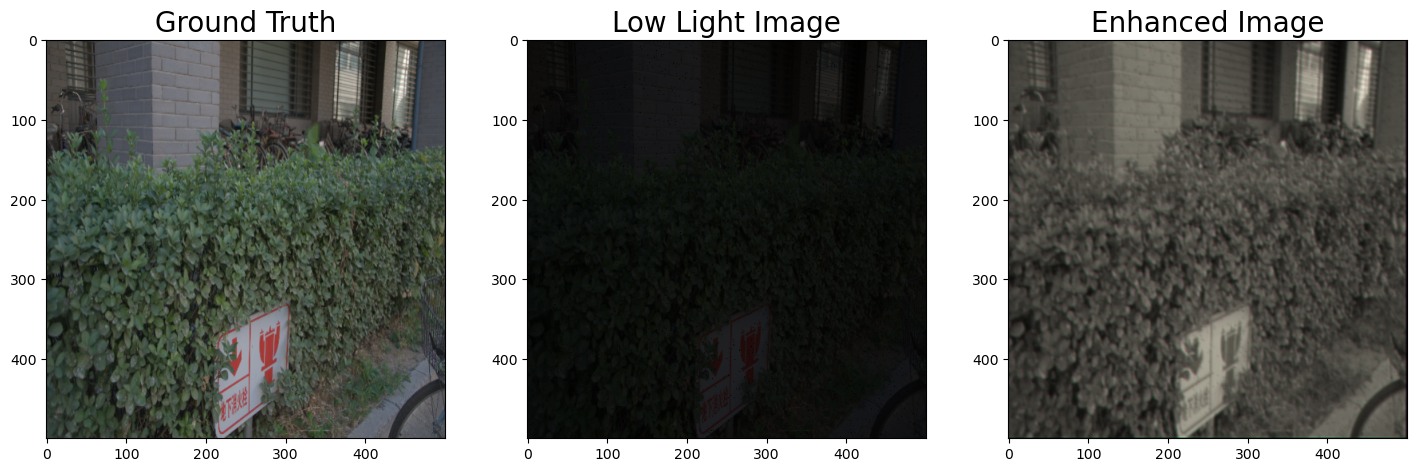

In [17]:
ImagePath=TestPath+"/722.png"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)
